<a href="https://colab.research.google.com/github/hieplh/PPR501/blob/main/Exercise_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas==1.1.3
!pip install pystan==2.19.1.1
!pip install fbprophet 

!pip install gdown
!rmdir dataset
!mkdir dataset

!gdown --folder https://drive.google.com/drive/folders/1DVCGeZnvEgdR9RQIhDaRTGHjeSGeCv7E?usp=sharing -O /content/dataset

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import time
import math
import datetime

import random
import seaborn as sns

# Import widgets
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import statsmodels.api as sm
import scipy
import statsmodels
from scipy import signal

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

import itertools
from itertools import cycle
plt.style.use('seaborn')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 8.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 101 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.2 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6638963 sha256=e0fe8cc589d2d05c0afd95b725176270a979e90bc7ef30df6696034451d52644
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492

# Loading files in pandas dataframes

In [ ]:
sell_prices_df = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/sell_prices.csv')
train_sales_df = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/sales_train_validation.csv')
calendar_df = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/calendar.csv')
submission_file = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/sample_submission.csv')

# Renaming column names of training set

In [ ]:
train_sales_df = pd.read_csv('https://media.githubusercontent.com/media/minhhieu9800/Python-MSE/main/Data/sales_train_validation.csv')
i = 0
for s in ((train_sales_df.columns)[6:]):
  i += 1
  train_sales_df.rename(columns={s:('s_' + str(i))}, inplace=True)
print(train_sales_df.columns)

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 's_1',
       's_2', 's_3', 's_4',
       ...
       's_1904', 's_1905', 's_1906', 's_1907', 's_1908', 's_1909', 's_1910',
       's_1911', 's_1912', 's_1913'],
      dtype='object', length=1919)


# Sales of first 5 items as time series

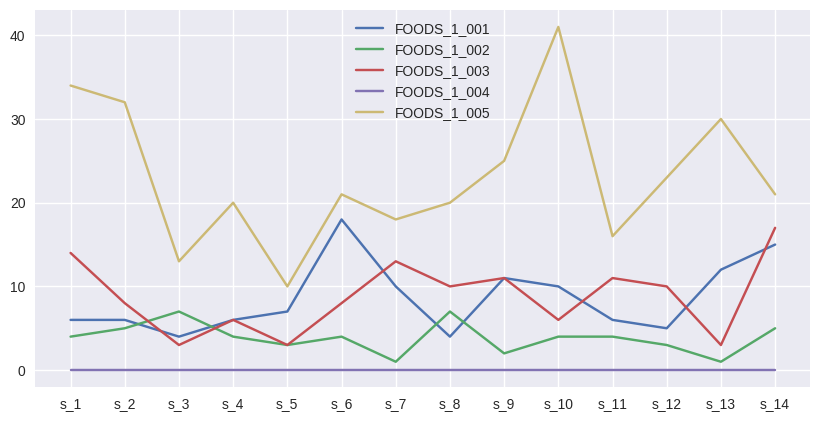

In [ ]:
total_sales = train_sales_df.groupby('item_id')[train_sales_df.columns[6:20]].sum()
plt.figure(num=None, figsize=(10, 5), dpi=100)
for i in range(5):
    plt.plot(total_sales.iloc[i,:], label=total_sales.index[i])
    plt.legend()
plt.show()

# Total sales as time series

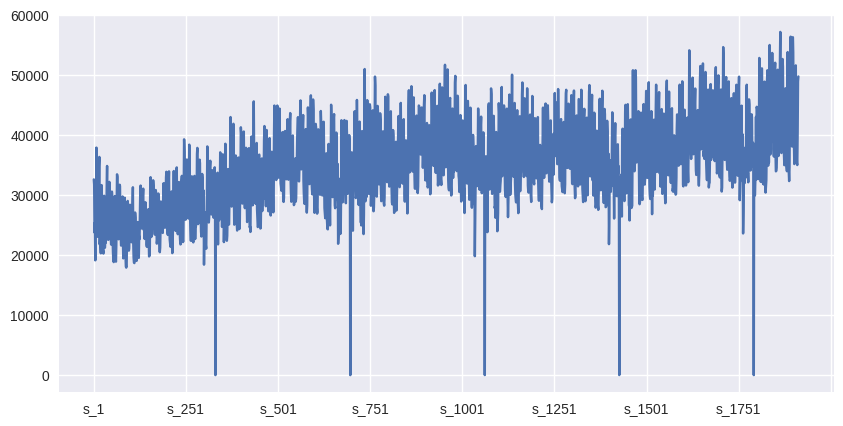

In [ ]:
total_sales = train_sales_df.groupby('item_id')[train_sales_df.columns[6:]].sum()
plt.figure(num=None, figsize=(10, 5), dpi=100)
total_sales.sum().plot()
plt.show()

# Monthly sales in different cities

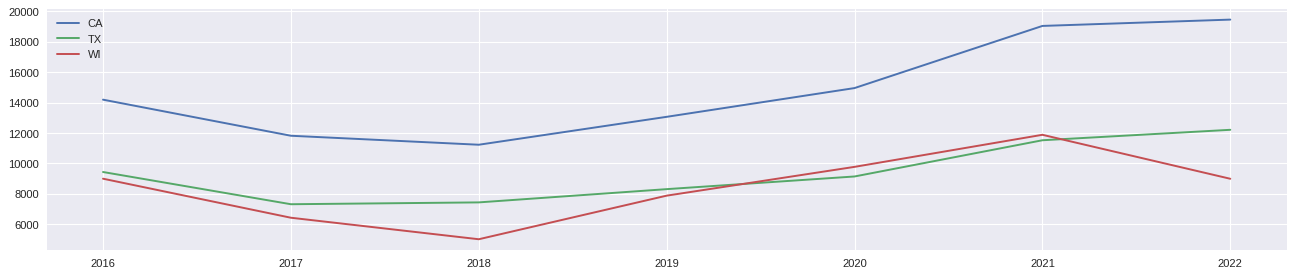

In [ ]:
setTrainSales = train_sales_df
setTrainSales = setTrainSales.groupby( \
    setTrainSales.columns.map(
      lambda x : x \
      if type(x) == str \
      else x.strftime('%Y-%m')), \
    axis=1) \
    .sum()

i = 2011;

for c in ((setTrainSales.columns)[:-6]):
    i += 1;
    x= i;
    setTrainSales.rename(columns={c:x},inplace=True)

setTrainSalesStateId = setTrainSales.groupby(['state_id'])[(setTrainSales.columns)[:-6]].sum()
plt.figure(num=None, figsize=(20, 4), dpi=80, facecolor='w', edgecolor='k')
for i in range(3):
    plt.plot(setTrainSalesStateId.iloc[i,0:7], label=setTrainSalesStateId.index[i])
    plt.legend(loc='best')
plt.show()

# Monthly sales of different categories

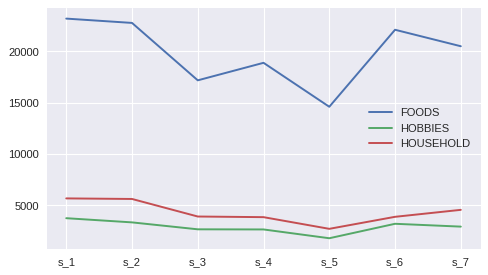

In [ ]:
setTrainSales = train_sales_df
setTrainSalesCatId = setTrainSales.groupby(['cat_id'])[(setTrainSales.columns)[:-6]].sum()
plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
for i in range(3):
    plt.plot(setTrainSalesCatId.iloc[i,0:7], label=setTrainSalesCatId.index[i])
    plt.legend(loc='best')
plt.show()

# Total Sales per category

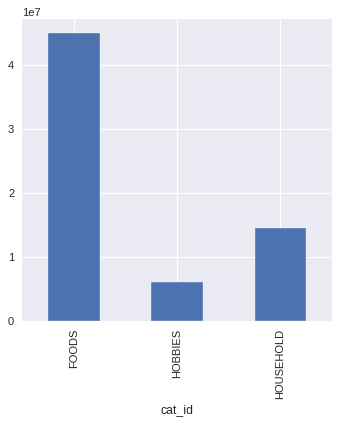

In [ ]:
setTrainSales = train_sales_df
setTrainSalesCatId = setTrainSales.groupby(['cat_id'])[(setTrainSales.columns)[:-6]].sum()
plt.figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
(setTrainSalesCatId.sum(axis=1)).plot.bar()
plt.show()

# Monthly sales in different stores

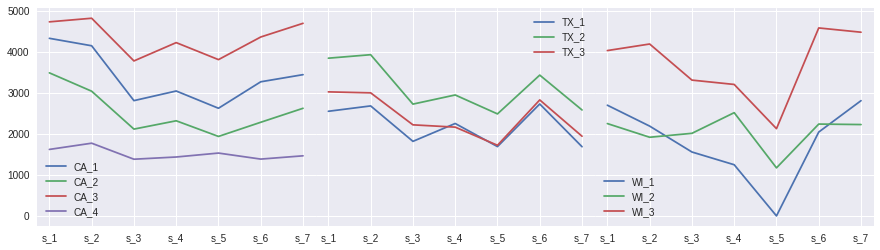

In [ ]:
setTrainSales = train_sales_df
setTrainSalesStoreId = setTrainSales.groupby(['store_id'])[(setTrainSales.columns)[:-6]].sum()
fig, ax = plt.subplots(1, 3, sharey=True, figsize = (15,4))
for i in range(10):
    n = lambda x : 0 if x == 'C' else (1 if x == 'T' else 2)
    n = n(setTrainSalesStoreId.index[i][0])
    ax[n].plot(setTrainSalesStoreId.iloc[i, 0:7], label=setTrainSalesStoreId.index[i])
    ax[n].grid(b=True, axis='y')
    ax[n].legend(loc='best')
fig.subplots_adjust( wspace=0.0)
plt.show()

# Monthly Sales in Different Departments of three States

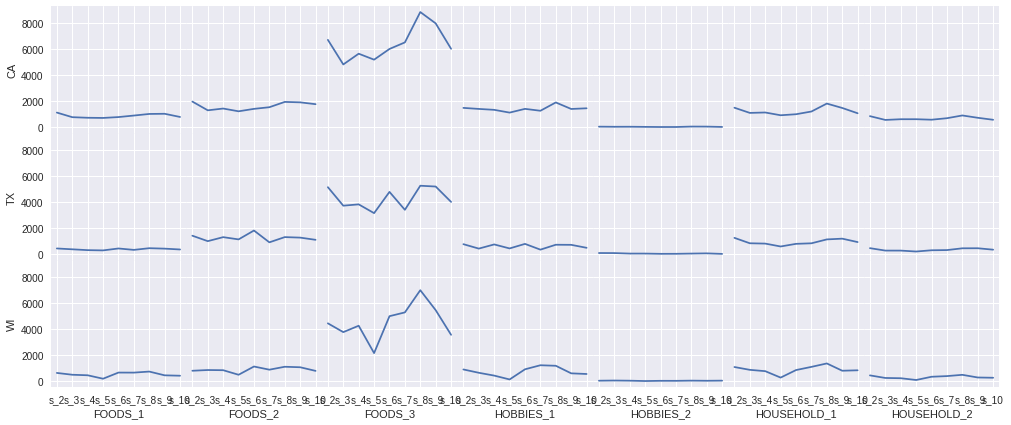

In [ ]:
setTrainSales = train_sales_df
setStateIdDeptId = setTrainSales.groupby(['state_id','dept_id'])[(setTrainSales.columns)[6:]].sum()
fig, ax = plt.subplots(3, 7, sharey=True, sharex=True, figsize = (17,7))
for i in range(3):
    for j in range(7):
        k = (7 * i) + (j)
        ax[i, j].plot(setStateIdDeptId.iloc[k, 1:10])
        ax[i, j].grid(b = True, axis = 'y')
        ax[i, j].set(xlabel = setStateIdDeptId.index[k][1], ylabel = setStateIdDeptId.index[k][0])
for a in ax.flat:
    a.label_outer()
fig.subplots_adjust(hspace = 0.0, wspace=0.0)
plt.show()

# Total Sales with Smoothing fit

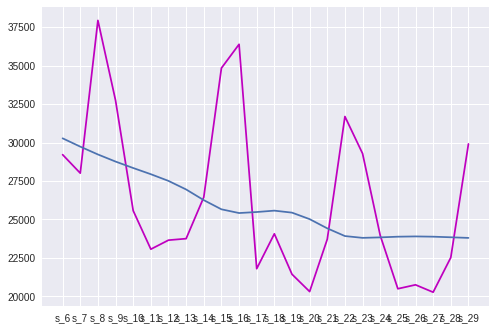

In [ ]:
setTrainSales = train_sales_df
F = setTrainSales.drop(labels = [\
                         's_1', \
                         's_2', \
                         's_3', \
                         's_4', \
                         's_5' \
                         ], axis=1)

lowess = sm.nonparametric.lowess
S = F.iloc[:, 6:30].sum()
z = lowess(S.values, range(S.shape[0]))
plt.plot(S, color='m')
plt.plot(pd.Series(z[:,1], S.index))

# Seasonality in Residuals

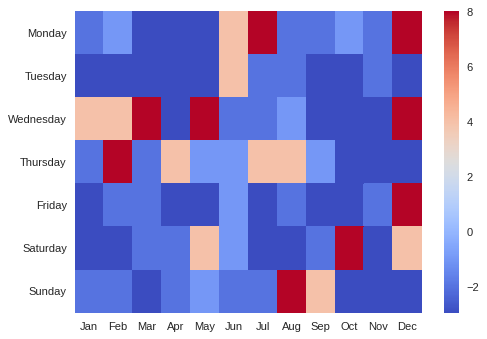

In [ ]:
M = F.iloc[:, 6:20].sum()
z = lowess(M, range(M.shape[0]))
Z = M.values - z[:, 1]
A = (pd.DataFrame(data=Z, index=M.index)).T
A = A.groupby(A.columns, axis=1).sum()
H = np.zeros((7, 12))
for i in range(7):
    for j in range(12):
        H[i, j] = A['s_' + str(random.randint(6, len(A.T)))] // 1000


plt.figure(None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(H, cmap='coolwarm', xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], \
                 yticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'])
plt.show()

# Sales per state with seasonalities

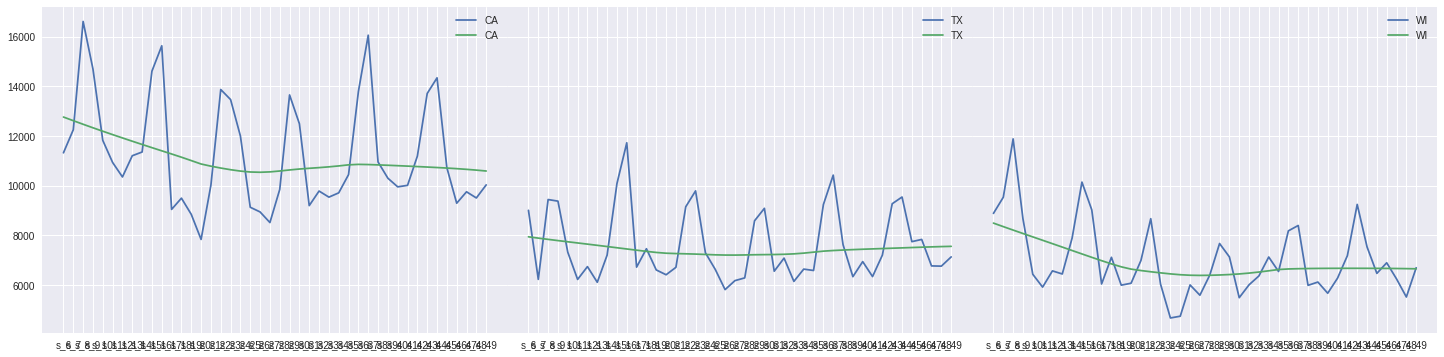

In [ ]:
M = F.groupby(['state_id'])[(F.columns)[0:50]].sum()

fig, ax = plt.subplots(1, 3, sharey=True, figsize = (25, 6))

for i in range(3):
    ax[i].plot(M.iloc[i,:], label=M.index[i])
    z = lowess(M.iloc[i,:].values, range(M.shape[1]))
    ax[i].plot(pd.Series(z[: ,1], M.columns), label=M.index[i])
    ax[i].grid(b=True, axis='y')
    ax[i].legend(loc='best')

fig.subplots_adjust(wspace=0.0)
plt.show()

# Weekly Seasonality

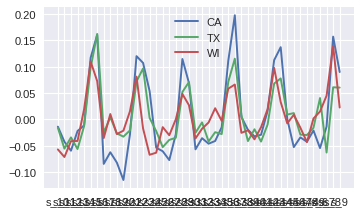

In [ ]:
mean_sales = F.iloc[:, 6:30].sum().mean()

A = M
for i in range(3):
    z = lowess(M.iloc[i,:].values, range(M.shape[1]))
    A.iloc[i,:] = M.iloc[i,:] - z[:,1]
A = A/mean_sales
A = A.groupby(A.columns, axis=1).sum()
plt.figure(num=None, figsize=(5, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(3):
    plt.plot(A.iloc[i,:], label=A.index[i])
    plt.legend(loc='best')

plt.show()

# Monthly Seasonality

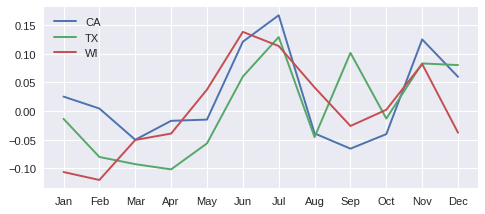

In [ ]:
A = M
for i in range(3):
    z = lowess(M.iloc[i,:12].values, np.random.random(12))
    A.iloc[i,:] = M.iloc[i,:12] - z[:,1]
A = A / mean_sales
A = A.iloc[:, :(np.sum(A.count()) // len(A))]

A = A.groupby(A.columns, axis=1).sum()
plt.figure(num=None, figsize=(7,3), dpi=80, facecolor='w', edgecolor='k')
for i in range(3):
    plt.plot(A.iloc[i,:],label=A.index[i])
    plt.legend(loc='best')
    plt.xticks(range(0, len(A.T)),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Weekly and monthly seasonalities by state and category

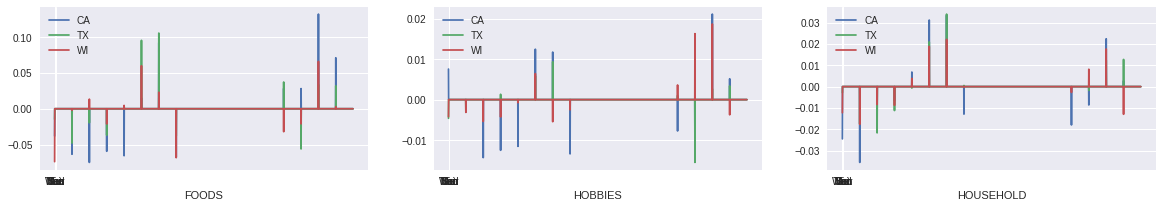

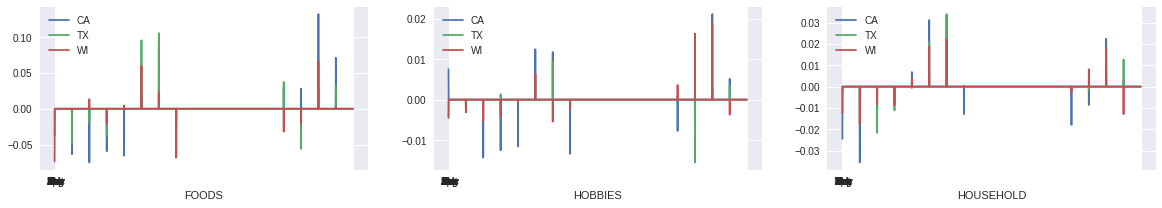

In [ ]:
M = F.groupby(['cat_id','state_id'])[(F.columns)[6:]].sum()
A = M
for i in range(9):
    z = lowess(M.iloc[i,:12].values, np.random.random(12))
    A.iloc[i,:] = M.iloc[i,:12] - z[:,1]
G = A / mean_sales

A = G.groupby(G.columns, axis=1).sum()
fig, ax = plt.subplots(1,3,figsize = (20,3), sharex=True)
for i in range(9):
    ax[(i//3)].plot(A.iloc[i,:],label=A.index[i][1])
    ax[(i//3)].legend(loc='best')
    ax[i//3].set(xlabel = A.index[i][0])
plt.xticks(range(0,7),['Mon', 'Tue', 'Wed', 'Thur', 'Fri','Sat','Sun' ])
plt.show()

B = G.groupby(G.columns, axis=1).sum()
fig, ax = plt.subplots(1,3,figsize = (20,3), sharex=True)
for i in range(9):
    ax[(i//3)].plot(B.iloc[i,:],label=B.index[i][1])
    ax[(i//3)].legend(loc='best')
    ax[i//3].set(xlabel = B.index[i][0])
plt.xticks(range(0,len(B.T)),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

# Event vs Non-event days

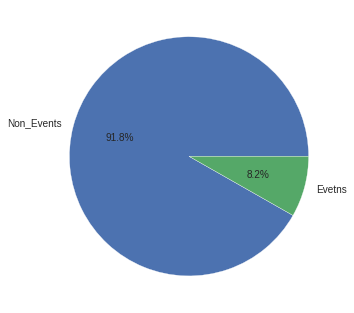

In [ ]:
Non_events = calendar_df.date.count() - calendar_df.event_name_1.count()
Events = calendar_df.event_name_1.count()
pd.Series([Non_events,Events], ['Non_Events',"Evetns"], name="").plot.pie(autopct='%1.1f%%')
plt.show()

# Relative number of types of events

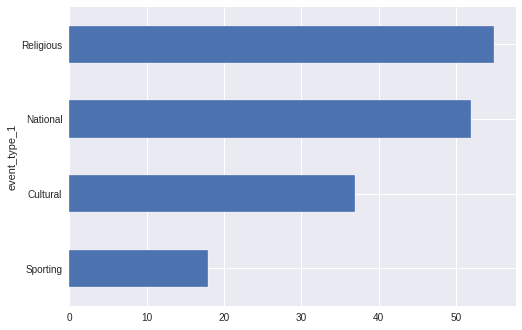

In [ ]:
calendar_df.groupby(['event_type_1']).count().iloc[:,1].sort_values(ascending=True).plot.barh()
plt.show()